In [1]:
from keras.utils import to_categorical
from keras_preprocessing.image import load_img
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import os
import pandas as pd
import numpy as np

2023-12-08 22:37:35.766406: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 22:37:35.766423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 22:37:35.767167: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 22:37:35.771625: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 22:37:36.397661: W tensorflow/compiler/tf2

Checking if the GPU is available to use

In [2]:
import tensorflow as tf
print("GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

GPUs Available:  1


2023-12-08 22:37:37.151109: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 22:37:37.172830: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 22:37:37.173074: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

This function serves as a data preparation step, converting raw image data into a structured format

In [3]:
def createdataframe(dir):
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        for imagename in os.listdir(os.path.join(dir,label)):
            image_paths.append(os.path.join(dir,label,imagename))
            labels.append(label)
        print(label, "completed")
    return image_paths,labels

In [4]:
#Testing to understand the path
import os
directory_name = 'images/train'
full_path = os.path.abspath(directory_name)
print("Full Path:", full_path)

Full Path: /home/adafrice/FACE_EMOTION_RECOGNITION/FACE_EMOTION_RECOGNITION/FACE_EMOTION_RECOGNITION/images/train


In [5]:
train = pd.DataFrame()
train['image'], train['label'] = createdataframe('images/train')

neutral completed
surprise completed
sad completed
angry completed
happy completed
disgust completed
fear completed


In [6]:
valid = pd.DataFrame()
valid['image'], valid['label'] = createdataframe('images/validation')

neutral completed
surprise completed
sad completed
angry completed
happy completed
disgust completed
fear completed


In [7]:
print(train)
print(valid)

                                image    label
0      images/train/neutral/35503.jpg  neutral
1       images/train/neutral/2452.jpg  neutral
2      images/train/neutral/28187.jpg  neutral
3      images/train/neutral/22436.jpg  neutral
4      images/train/neutral/28747.jpg  neutral
...                               ...      ...
28816      images/train/fear/7605.jpg     fear
28817     images/train/fear/28244.jpg     fear
28818     images/train/fear/20427.jpg     fear
28819     images/train/fear/14602.jpg     fear
28820      images/train/fear/1509.jpg     fear

[28821 rows x 2 columns]
                                    image    label
0     images/validation/neutral/22886.jpg  neutral
1      images/validation/neutral/1339.jpg  neutral
2     images/validation/neutral/33471.jpg  neutral
3     images/validation/neutral/18208.jpg  neutral
4     images/validation/neutral/14550.jpg  neutral
...                                   ...      ...
7061     images/validation/fear/31157.jpg     fear
70

In [8]:
from tqdm.notebook import tqdm

This function prepares image data for machine learning by loading, converting, and reshaping the images into a format suitable for input into a model. The extracted features are organized into a NumPy array, where each image is represented as a 48x48 matrix with a single channel.

In [9]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        features.append(np.array(load_img(image,color_mode="grayscale")))
    features = np.array(features)
    features = features.reshape(len(features),48,48,1)
    return features

In [10]:
train_features = extract_features(train['image']) 
valid_features = extract_features(valid['image'])

  0%|          | 0/28821 [00:00<?, ?it/s]

  0%|          | 0/7066 [00:00<?, ?it/s]

In [11]:
x_train = train_features/255.0
x_valid = valid_features/255.0

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])

LabelEncoder()

In [13]:
y_train = le.transform(train['label'])
y_valid = le.transform(valid['label'])

In [14]:
# Convert class labels in y_train and y_valid to one-hot encoded format
y_train = to_categorical(y_train,num_classes = 7)
y_valid = to_categorical(y_valid,num_classes = 7)

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

This is a convolutional neural network (CNN) model using the Keras library with a TensorFlow backend. There are four convolutional layers that we have talked about in lecture. After the convolutional layers, a flattening layer is added to flatten the multi-dimensional output into a one-dimensional array, preparing it for the fully connected layers.

In [16]:
model = Sequential([
    #four convolutional layers for our model
    Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(48,48,1)),
    MaxPooling2D(pool_size=(2,2), strides=2),

    Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),

    Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),

    Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')
])

2023-12-08 22:37:40.877628: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 22:37:40.877852: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 22:37:40.877971: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

To prevent overfitting and enhance efficiency, early stopping is employed. The early stopping mechanism restores the model weights from the end of the best epoch.

In [17]:
es_callback = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True, mode='min')
cp_callback = ModelCheckpoint(monitor='val_loss', save_best_only=True,
                              save_weights_only=True, filepath='emotion_model.weights')
#USing an adam optimizer
optimizer = Adam(learning_rate=0.001)

In [18]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics='accuracy' )
model.fit(x= x_train, y=y_train, batch_size=128, epochs=3000,
          validation_data=(x_valid,y_valid), callbacks=[es_callback, cp_callback])

Epoch 1/3000


2023-12-08 22:37:42.117987: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2023-12-08 22:37:45.171490: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f02a51639c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-08 22:37:45.171502: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2023-12-08 22:37:45.175947: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702075065.253743   21567 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


181/181 [==============================] - 28s 109ms/step - loss: 1.8208 - accuracy: 0.2431 - val_loss: 1.7831 - val_accuracy: 0.2586
Epoch 2/3000
181/181 [==============================] - 17s 97ms/step - loss: 1.7501 - accuracy: 0.2692 - val_loss: 1.6425 - val_accuracy: 0.3491
Epoch 3/3000
181/181 [==============================] - 18s 97ms/step - loss: 1.5680 - accuracy: 0.3779 - val_loss: 1.4486 - val_accuracy: 0.4338
Epoch 4/3000
181/181 [==============================] - 18s 98ms/step - loss: 1.3674 - accuracy: 0.4673 - val_loss: 1.3315 - val_accuracy: 0.4898
Epoch 5/3000
181/181 [==============================] - 18s 98ms/step - loss: 1.2627 - accuracy: 0.5140 - val_loss: 1.2434 - val_accuracy: 0.5258
Epoch 6/3000
181/181 [==============================] - 18s 98ms/step - loss: 1.1747 - accuracy: 0.5491 - val_loss: 1.2026 - val_accuracy: 0.5501
Epoch 7/3000
181/181 [==============================] - 18s 98ms/step - loss: 1.0979 - accuracy: 0.5824 - val_loss: 1.2004 - val_accurac

In [19]:
from keras.metrics import CategoricalAccuracy
category = CategoricalAccuracy()
category.update_state(y_test, model.predict(x_test))
print('Accuracy:', category.result().numpy())

181/181 [==============================] - 3s 10ms/step
Accuracy: 0.5538595


Saving the models and weights we already have a presaved model so we just commented out how we saved our data.

In [20]:
model_json = model.to_json()
with open("emotion_model.json",'w') as json_file:
    json_file.write(model_json)
model.load_weights("emotion_model.weights")

In [21]:
label = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [22]:
def img_filepath(image):
    feature = np.array(load_img(image, color_mode="grayscale"))
    feature = feature.reshape(1,48,48,1)
    return feature/255.0

Here we tried to see if we can replicate and see if our trained model actually works. I compare the actual answer to our prediciton.

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

The original is Sad
1/1 [==============================] - 0s 355ms/step
Our Model is  fear


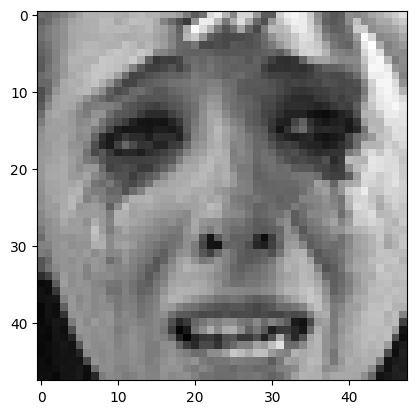

In [24]:
image = 'images/train/sad/54.jpg'
print("The original is Sad")
img = img_filepath(image)
print("Our Model is ",label[model.predict(img).argmax()])
plt.imshow(img.reshape(48,48),cmap='gray')

The original is Fear
1/1 [==============================] - 0s 13ms/step
Our Model is  angry


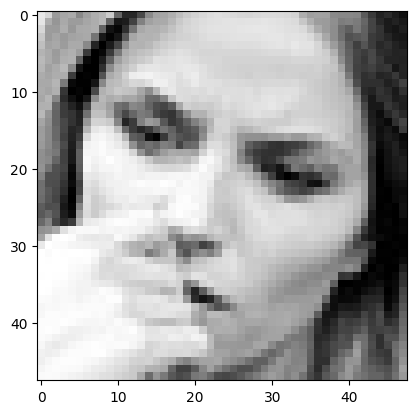

In [25]:
image = 'images/train/fear/2.jpg'
print("The original is Fear")
img = img_filepath(image)
print("Our Model is ",label[model.predict(img).argmax()])
plt.imshow(img.reshape(48,48),cmap='gray')

The original is Angry
1/1 [==============================] - 0s 14ms/step
Our Model is  angry


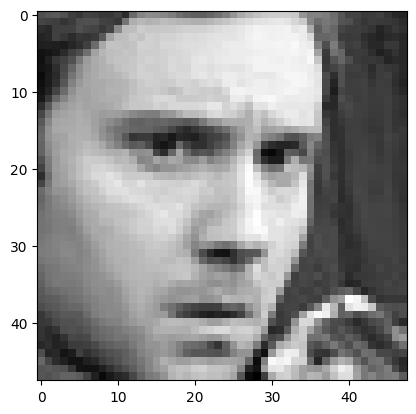

In [26]:
image = 'images/train/angry/0.jpg'
print("The original is Angry")
img = img_filepath(image)
print("Our Model is ",label[model.predict(img).argmax()])
plt.imshow(img.reshape(48,48),cmap='gray')

The original is Fear
1/1 [==============================] - 0s 16ms/step
Our Model is  sad


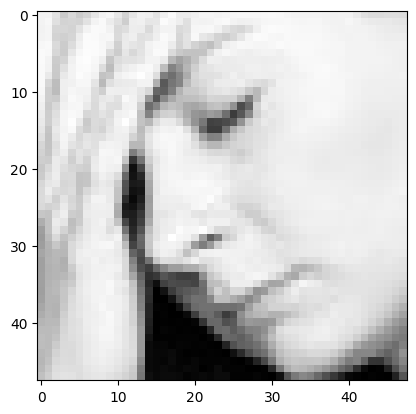

In [27]:
image = 'images/train/fear/121.jpg'
print("The original is Fear")
img = img_filepath(image)
print("Our Model is ",label[model.predict(img).argmax()])
plt.imshow(img.reshape(48,48),cmap='gray')

The original is Suprise
1/1 [==============================] - 0s 14ms/step
Our Model is  surprise


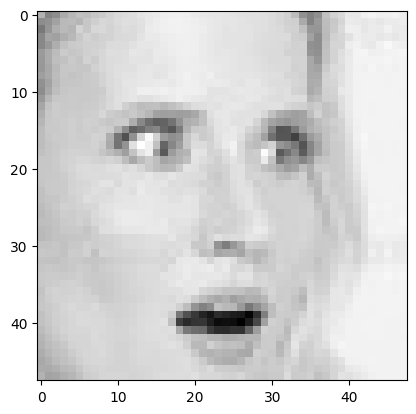

In [28]:
image = 'images/train/surprise/61.jpg'
print("The original is Suprise")
img = img_filepath(image)
print("Our Model is ",label[model.predict(img).argmax()])
plt.imshow(img.reshape(48,48),cmap='gray')